/var/folders/dk/p3hrckf56t30z4249nxtjr0m0000gn/T/ipykernel_39520/3273465598.py:55: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/jonas/.local/share/virtualenvs/Jupyter-K0eqoyk3/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



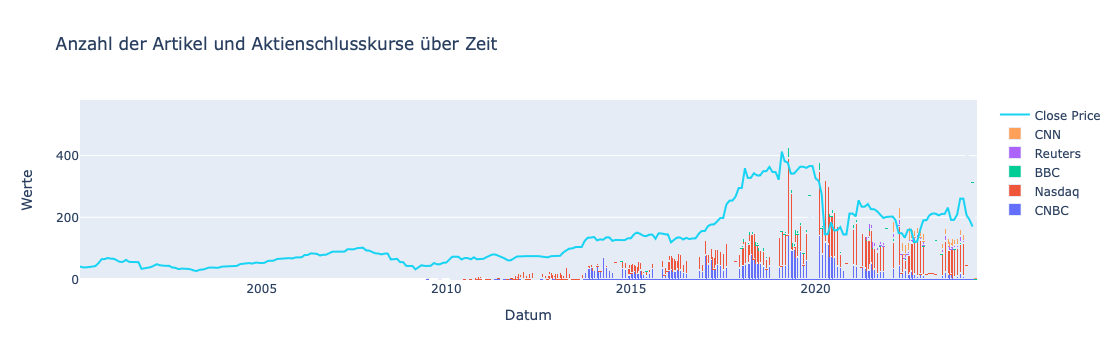

Anzahl ungültiger Artikel: 8


In [5]:
import pandas as pd
import plotly.graph_objects as go
from pymongo import MongoClient
from datetime import datetime

# MongoDB-Verbindungsdaten aktualisieren
username = 'admin'
password = 'admin'
host = 'localhost'
port = '27017'
authSource = 'admin'
mongo_uri = f'mongodb://{username}:{password}@{host}:{port}/?authSource={authSource}'

# Verbindung zur MongoDB
client = MongoClient(mongo_uri)
db = client['web_articles']
collection = db['articles']

# Daten aus MongoDB abrufen
data = list(collection.find({}))

# Verarbeitung der Artikel-Daten
article_dates = []
publishers = []
invalid_article_count = 0

for article in data:
    publish_date = article.get('publish_date', 'nan')
    publisher = article.get('article_publisher', 'Unbekannter Verlag')
    try:
        if publish_date != 'nan':
            parsed_date = datetime.strptime(publish_date, "%Y-%m-%dT%H:%M:%S+00:00")
            article_dates.append(parsed_date)
            publishers.append(publisher)
    except ValueError:
        invalid_article_count += 1

article_df = pd.DataFrame({
    'publish_date': article_dates,
    'article_publisher': publishers
})
article_df['count'] = 1
article_df.set_index('publish_date', inplace=True)
article_resampled = article_df.groupby([pd.Grouper(freq='M'), 'article_publisher']).sum().reset_index()

# CSV-Daten einlesen und verarbeiten
stock_data = pd.read_csv('../../stock_price/01_01_2000_to_18_04_2024.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data['Close'] = stock_data['Close'].astype(float)
stock_data['Volume'] = stock_data['Volume'].str.replace(',', '').astype(int)  # Entfernen der Kommas und Konvertieren in int

# Monatlich aggregieren und fehlende Monate auffüllen
stock_monthly = stock_data.resample('M', on='Date').mean()['Close'].reset_index()
stock_monthly.set_index('Date', inplace=True)
stock_monthly = stock_monthly.asfreq('M').fillna(method='ffill').reset_index()  # Auffüllen der fehlenden Monate

# Diagramm erstellen
fig = go.Figure()

# Artikel-Daten als Balken
for publisher in article_resampled['article_publisher'].unique():
    publisher_data = article_resampled[article_resampled['article_publisher'] == publisher]
    fig.add_trace(go.Bar(x=publisher_data['publish_date'], y=publisher_data['count'], name=publisher))

# Stock-Daten als Linie
fig.add_trace(go.Scatter(x=stock_monthly['Date'], y=stock_monthly['Close'], mode='lines', name='Close Price'))

# Layout-Update
fig.update_layout(title='Anzahl der Artikel und Aktienschlusskurse über Zeit',
                  xaxis_title='Datum',
                  yaxis_title='Werte',
                  barmode='stack')

#fig.show(renderer='browser')
fig.show()

print(f"Anzahl ungültiger Artikel: {invalid_article_count}")
